# Librairies

In [1]:
import csv
import json
import os 
import h5py

import torch
import numpy as np

import sys

# Ajouter le chemin du dossier parent au sys.path
# Use the current working directory as the base path in Jupyter Notebook
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importer le fichier ESN.py depuis le sous-dossier
from models.ESN import ESN

import models.trainer as trainer
import models.hfno_2D_ww as fno
from torch.utils.data import DataLoader, TensorDataset #to manage datasets and bash 

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

# DATA IMPORTATION

In [2]:
### DATA IMPORT
# Load the data

### FUNCTION DEFINITION ###

def print_carac(dt, ndim, nf, nk, re, resolution, time):

    print("dt: {} ; ndim: {} ; nf: {} ; k: {} ; re: {} ; resolution: {} ; simulation time: {}".format(dt, ndim, nf, nk, re, resolution, time[-1]))

##### IMPORT DATA #####

print("Data importation...")

filename = "../data/kolmogorov/RE90/results2.h5"

with h5py.File(filename, "r") as f:

    dissipation = f["dissipation"][()]
    dt = f["dt"][()]
    ndim = f["ndim"][()]
    nf = f["nf"][()]
    nk = f["nk"][()]
    re = f["re"][()]
    resolution = f["resolution"][()]
    time = f["time"][()]
    velocity_field = f["velocity_field"][()]
    print_carac(dt, ndim, nf, nk, re, resolution, time)

print("Importation done!")


last_mode_ESN = 15
washout=[100]
p_val = 0.3

n = velocity_field.shape[0]
n_training = int(np.floor((1-p_val)*n))

if isinstance(velocity_field, np.ndarray):
    velocity_field = torch.from_numpy(velocity_field).type(dtype=torch.float32)
input_train = velocity_field[:n_training,...]
output_train = velocity_field[1:(n_training+1)]
input_test = velocity_field[n_training:-1]
output_test = velocity_field[n_training+1:]


n_train = input_train.shape[0]
n_test = input_test.shape[0]

Data importation...
dt: 0.001 ; ndim: 2 ; nf: 4 ; k: 32 ; re: 90.0 ; resolution: 128 ; simulation time: 599.999
Importation done!


# MODEL LOADING

In [3]:

model_name = "re90_4_8_15"
loaded_combined_model_dict = torch.load(os.path.join("./trained_models_esn",model_name+".pt"))

# Accéder aux modèles
fno_model = loaded_combined_model_dict["fno_model"]
esn_model = loaded_combined_model_dict["esn_model"]

print("Combined model dictionary loaded successfully!")

/var/folders/53/d3ng48y138s7ldywsyn64jj00000gn/T/ipykernel_39664/2681156819.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_combined_model_dict = torch.load(os.pa

Combined model dictionary loaded successfully!


In [4]:
fno_model.width_MLP

128

# ESN I/O pre-processing

In [5]:
def esn_input(input_velocity, k_cutoff_start, k_cutoff_end):

    kxx = np.fft.fftfreq(resolution, d=1.0) 
    kyy = np.fft.fftfreq(resolution, d=1.0)  
    kx, ky = np.meshgrid(kxx, kyy, indexing='ij')
    k_magnitude = np.sqrt(kx**2 + ky**2) 
    rk_magnitude = k_magnitude[:,:resolution//2+1]

    mask = np.logical_and(rk_magnitude <= k_cutoff_end, rk_magnitude >= k_cutoff_start)

    velocity_field = input_velocity
    fft_vel = torch.fft.rfft2(velocity_field, axis=(1, 2))
    filtered_fft_vel = fft_vel[:,mask,:]
    filtered_fft_vel = torch.concatenate((filtered_fft_vel.real.unsqueeze(-1),filtered_fft_vel.imag.unsqueeze(-1)), axis=-1)
    W_input = filtered_fft_vel.reshape(filtered_fft_vel.shape[0],-1)

    print("Input size: {}".format(W_input.shape[-1]))
    return W_input

def esn_output(residuals, k_cutoff_end, k_cutoff_start=0):

    kxx = np.fft.fftfreq(resolution, d=1.0) 
    kyy = np.fft.fftfreq(resolution, d=1.0)  
    kx, ky = np.meshgrid(kxx, kyy, indexing='ij')
    k_magnitude = np.sqrt(kx**2 + ky**2) 
    rk_magnitude = k_magnitude[:,:resolution//2+1]

    mask = np.logical_and(rk_magnitude <= k_cutoff_end, rk_magnitude >= k_cutoff_start)

    fft_res = torch.fft.rfft2(residuals, axis=(1,2))
    filtered_fft_res = fft_res[:,mask,:]
    filtered_fft_res = torch.concatenate((filtered_fft_res.real.unsqueeze(-1),filtered_fft_res.imag.unsqueeze(-1)), axis=-1)
    W_output = filtered_fft_res.reshape(filtered_fft_res.shape[0],-1)

    print("Output size: {}".format(W_output.shape[-1]))
    return W_output


with torch.no_grad():
    preds_fno_train = fno_model(input_train)
    preds_fno_test = fno_model(input_test)

    residuals_train = output_train - preds_fno_train
    residuals_test = output_test - preds_fno_test


k_start_esn = fno_model.modes[-1]/resolution
k_end_esn = last_mode_ESN/resolution


W_input_train = esn_input(input_train, k_start_esn, k_end_esn)
W_output_train = esn_output(residuals_train, k_end_esn, k_start_esn)

W_input_test = esn_input(input_test, k_start_esn, k_end_esn)
W_output_test = esn_output(residuals_test, k_end_esn, k_start_esn)


Input size: 1064
Output size: 1064
Input size: 1064
Output size: 1064


# Predictions

In [ ]:
output_esn_train = np.zeros((n_train-washout[0], resolution, resolution//2+1, 2), dtype=np.cfloat)
output_esn_test = np.zeros((n_test-washout[0], resolution, resolution//2+1, 2), dtype=np.cfloat)

pred_esn_train = esn_model.predict(W_input_train)
pred_esn_test = esn_model.predict(W_input_test)
pred_esn_train_rs = pred_esn_train.reshape(pred_esn_train.shape[0],pred_esn_train.shape[-1]//2,2)
pred_esn_train_modes = pred_esn_train_rs[...,0] + 1j*pred_esn_train_rs[...,1]

pred_esn_test_rs = pred_esn_test.reshape(pred_esn_test.shape[0],pred_esn_train.shape[-1]//2,2)
pred_esn_test_modes = pred_esn_test_rs[...,0] + 1j*pred_esn_test_rs[...,1]


kxx = np.fft.fftfreq(resolution, d=1.0) 
kyy = np.fft.fftfreq(resolution, d=1.0)  
kx, ky = np.meshgrid(kxx, kyy, indexing='ij')
k_magnitude = np.sqrt(kx**2 + ky**2) 
rk_magnitude = k_magnitude[:,:resolution//2+1]

mask = np.logical_and(rk_magnitude <= k_end_esn, rk_magnitude >= k_start_esn)
output_esn_train = np.zeros((n_train-washout[0], resolution, resolution//2+1, 2), dtype=np.cfloat)
output_esn_test = np.zeros((n_test-washout[0], resolution, resolution//2+1, 2), dtype=np.cfloat)

pred_esn_train = esn_model.predict(W_input_train)
pred_esn_test = esn_model.predict(W_input_test)
pred_esn_train_rs = pred_esn_train.reshape(pred_esn_train.shape[0],pred_esn_train.shape[-1]//4,2,2)
pred_esn_train_modes = pred_esn_train_rs[...,0] + 1j*pred_esn_train_rs[...,1]

pred_esn_test_rs = pred_esn_test.reshape(pred_esn_test.shape[0],pred_esn_train.shape[-1]//4,2,2)
pred_esn_test_modes = pred_esn_test_rs[...,0] + 1j*pred_esn_test_rs[...,1]


kxx = np.fft.fftfreq(resolution, d=1.0) 
kyy = np.fft.fftfreq(resolution, d=1.0)  
kx, ky = np.meshgrid(kxx, kyy, indexing='ij')
k_magnitude = np.sqrt(kx**2 + ky**2) 
rk_magnitude = k_magnitude[:,:resolution//2+1]

mask = np.logical_and(rk_magnitude <= k_end_esn, rk_magnitude >= k_start_esn)
#mask = rk_magnitude <= k_end_W

output_esn_train[:,mask,:] = pred_esn_train_modes
output_esn_test[:,mask,:] = pred_esn_test_modes

output_esn_ps_train = np.fft.irfft2(output_esn_train, axes=(1,2))
output_esn_ps_test = np.fft.irfft2(output_esn_test, axes=(1,2))
full_pred_train = preds_fno_train[100:] + output_esn_ps_train
full_pred_test = preds_fno_test[100:] + output_esn_ps_test


preds_fno_1_train = fno_model(input_train, indexes=[0])
preds_fno_2_train = fno_model(input_train, indexes=[1])
preds_fno_1_test = fno_model(input_test, indexes=[0])
preds_fno_2_test = fno_model(input_test, indexes=[1])


error_train = output_train[100:] - full_pred_train
error_test = output_test[100:] - full_pred_test


# PLOT RESULTS

## Energy spectrum

In [ ]:
def compute_classical_energy_spectrum(u):
        """
        Spectre classique par FFT directe des composantes de vitesse
        u : ndarray (t, nx, ny, 2)
        Returns: k_vals_classical, E_k_classical
        """
        tsteps, nx, ny, _ = u.shape
        E_k_sum = 0.0

        for t in range(tsteps):
            ux = u[t, :, :, 0]
            uy = u[t, :, :, 1]

            uxf = np.fft.fft2(ux)
            uyf = np.fft.fft2(uy)

            E2D = 0.5 * (np.abs(uxf)**2 + np.abs(uyf)**2) / (nx * ny)
            E2D = np.fft.fftshift(E2D)

            # Build radial wavenumber grid
            kx = np.fft.fftshift(np.fft.fftfreq(nx)) * nx
            ky = np.fft.fftshift(np.fft.fftfreq(ny)) * ny
            KX, KY = np.meshgrid(kx, ky, indexing='ij')
            k_mag = np.sqrt(KX**2 + KY**2)

            k_max = int(np.max(k_mag))
            E_k = np.zeros(k_max)
            for i in range(k_max):
                mask = (k_mag >= i) & (k_mag < i + 1)
                E_k[i] += np.sum(E2D[mask])

            E_k_sum += E_k

        E_k_classical = E_k_sum / tsteps
        k_vals_classical = np.arange(len(E_k_classical))
        return k_vals_classical, E_k_classical

In [ ]:
k_bin_centers, spectrum_binned_data = compute_classical_energy_spectrum(velocity_field)
_, spectrum_binned_fno_1 = compute_classical_energy_spectrum(preds_fno_1_train.detach().numpy())
_, spectrum_binned_fno_2 = compute_classical_energy_spectrum(preds_fno_2_train.detach().numpy())
_, spectrum_binned_esn = compute_classical_energy_spectrum(output_esn_ps_train)
_, spectrum_binned_full = compute_classical_energy_spectrum(full_pred_train.detach().numpy())
_, spectrum_binned_error = compute_classical_energy_spectrum(error_train.detach().numpy())

cumulative_energy = np.cumsum(spectrum_binned_data)
total_energy = cumulative_energy[-1]
normalized_cumulative_energy = cumulative_energy / total_energy

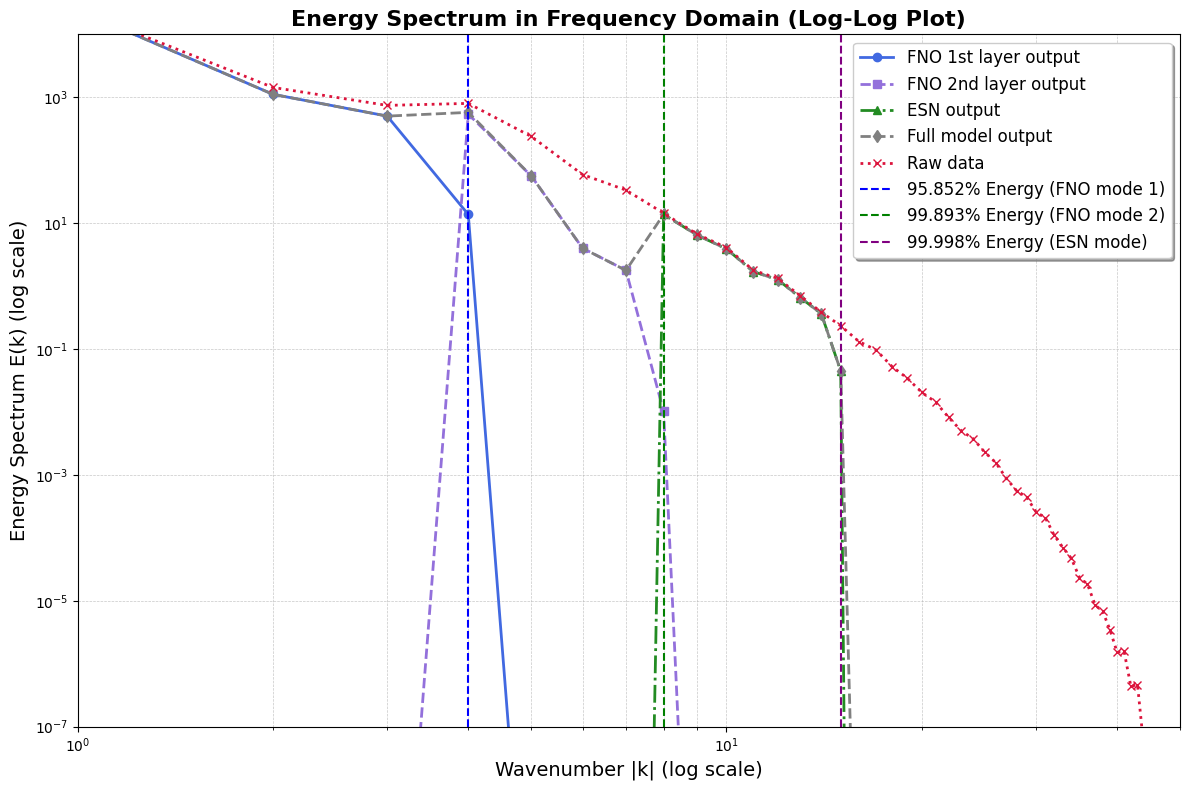

In [31]:
plt.figure(figsize=(12, 8))

# Courbes avec des couleurs et styles distincts
plt.loglog(k_bin_centers, spectrum_binned_fno_1, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6, label='FNO 1st layer output')
plt.loglog(k_bin_centers, spectrum_binned_fno_2, marker='s', linestyle='--', color='mediumpurple', linewidth=2, markersize=6, label='FNO 2nd layer output')
plt.loglog(k_bin_centers, spectrum_binned_esn, marker='^', linestyle='-.', color='forestgreen', linewidth=2, markersize=6, label='ESN output')
plt.loglog(k_bin_centers, spectrum_binned_full, marker='d', linestyle='--', color='grey', linewidth=2, markersize=6, label='Full model output')
plt.loglog(k_bin_centers, spectrum_binned_data, marker='x', linestyle=':', color='crimson', linewidth=2, markersize=6, label='Raw data')

# Lignes verticales pour les modes
plt.axvline(fno_model.modes[0], color='blue', linestyle='--', linewidth=1.5, label=f'{np.round(normalized_cumulative_energy[fno_model.modes[0]-1]*100,3)}% Energy (FNO mode 1)')
plt.axvline(fno_model.modes[1], color='green', linestyle='--', linewidth=1.5, label=f'{np.round(normalized_cumulative_energy[fno_model.modes[1]-1]*100,3)}% Energy (FNO mode 2)')
plt.axvline(last_mode_ESN, color='purple', linestyle='--', linewidth=1.5, label=f'{np.round(normalized_cumulative_energy[last_mode_ESN-1]*100,3)}% Energy (ESN mode)')

# Ajustements des limites et des étiquettes
plt.ylim(1e-7, 1e4)
plt.xlim(1,50)
plt.xlabel('Wavenumber |k| (log scale)', fontsize=14)
plt.ylabel('Energy Spectrum E(k) (log scale)', fontsize=14)
plt.title('Energy Spectrum in Frequency Domain (Log-Log Plot)', fontsize=16, fontweight='bold')

# Grille et légende
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)

# Affichage
plt.tight_layout()
plt.show()

In [9]:
plt.figure(figsize=(12, 8))

# Courbes avec des couleurs et styles distincts
plt.loglog(k_bin_centers, spectrum_binned_fno_1, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6, label='FNO 1st layer output')
plt.loglog(k_bin_centers, spectrum_binned_fno_2, marker='s', linestyle='--', color='mediumpurple', linewidth=2, markersize=6, label='FNO 2nd layer output')
plt.loglog(k_bin_centers, spectrum_binned_esn, marker='^', linestyle='-.', color='forestgreen', linewidth=2, markersize=6, label='ESN output')
#plt.loglog(k_bin_centers, spectrum_binned_full, marker='d', linestyle='--', color='grey', linewidth=2, markersize=6, label='Full model output')
plt.loglog(k_bin_centers, spectrum_binned_data, marker='x', linestyle=':', color='crimson', linewidth=2, markersize=6, label='Raw data')

# Lignes verticales pour les modes avec étiquettes au-dessus
plt.axvline(fno_model.modes[0], color='blue', linestyle='--', linewidth=1.5)
plt.text(fno_model.modes[0]*1.39, 1e3, f'{np.round(normalized_cumulative_energy[fno_model.modes[0]-1]*100,3)}% Energy\n(FNO mode 1)', 
         color='blue', fontsize=14, ha='center')

plt.axvline(fno_model.modes[1], color='purple', linestyle='--', linewidth=1.5)
plt.text(fno_model.modes[1]*1.39, 5e1, f'{np.round(normalized_cumulative_energy[fno_model.modes[1]-1]*100,3)}% Energy\n(FNO mode 2)', 
         color='purple', fontsize=14, ha='center')

plt.axvline(last_mode_ESN, color='green', linestyle='--', linewidth=1.5)
plt.text(last_mode_ESN*1.39, 1, f'{np.round(normalized_cumulative_energy[last_mode_ESN-1]*100,3)}% Energy\n(ESN mode)', 
         color='green', fontsize=14, ha='center')

# Ajustements des limites et des étiquettes
plt.ylim(1e-7, 1e4)
plt.xlim(1, 50)
plt.xlabel('Wavenumber |k| (log scale)', fontsize=20)
plt.ylabel('Energy Spectrum E(k) (log scale)', fontsize=20)
plt.title('Energy Spectrum in Frequency Domain (Log-Log Plot)', fontsize=22, fontweight='bold')

# Grille et légende
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16, loc='best', frameon=True, shadow=True)

# Affichage
plt.tight_layout()
plt.show()

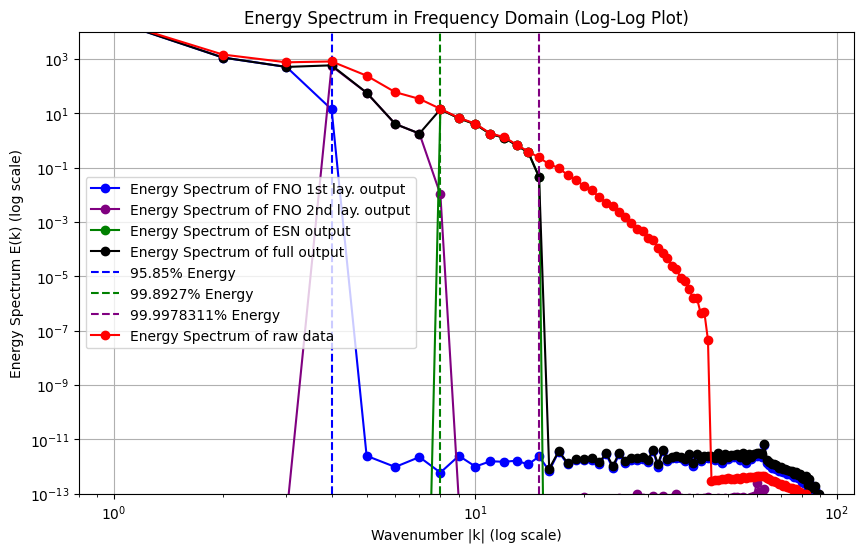

In [22]:
    plt.figure(figsize=(10, 6))
    plt.loglog(k_bin_centers, spectrum_binned_fno_1, marker='o', linestyle='-', color='b', label='Energy Spectrum of FNO 1st lay. output')
    plt.loglog(k_bin_centers, spectrum_binned_fno_2, marker='o', linestyle='-', color='purple', label='Energy Spectrum of FNO 2nd lay. output')
    plt.loglog(k_bin_centers, spectrum_binned_esn, marker='o', linestyle='-', color='g', label='Energy Spectrum of ESN output')
    plt.loglog(k_bin_centers, spectrum_binned_full, marker='o', linestyle='-', color='black', label='Energy Spectrum of full output')
    #plt.loglog(k_bin_centers, spectrum_binned_error, marker='o', linestyle='-', color='pink', label='Energy Spectrum of the error')
    plt.axvline(fno_model.modes[0], color='blue', linestyle='--', label=f'{np.round(normalized_cumulative_energy[fno_model.modes[0]-1]*100,2)}% Energy')
    plt.axvline(fno_model.modes[1], color='green', linestyle='--', label=f'{np.round(normalized_cumulative_energy[fno_model.modes[1]-1]*100,4)}% Energy')
    plt.axvline(last_mode_ESN, color='purple', linestyle='--', label=f'{np.round(normalized_cumulative_energy[last_mode_ESN-1]*100,7)}% Energy')

    plt.loglog(k_bin_centers, spectrum_binned_data, marker='o', linestyle='-', color='r', label='Energy Spectrum of raw data')


    plt.ylim(1e-13,1e4)
    plt.xlabel('Wavenumber |k| (log scale)')
    plt.ylabel('Energy Spectrum E(k) (log scale)')
    plt.title('Energy Spectrum in Frequency Domain (Log-Log Plot)')
    plt.grid(True)
    plt.legend()
    plt.show()

## Vorticities

In [13]:
def compute_vorticity(vel_field):
       with torch.no_grad():
              u = vel_field[..., 0]  # shape (1000, 64, 64)
              v = vel_field[..., 1]  # shape (1000, 64, 64)

              dv_dx = torch.gradient(v, dim=2)[0]
              du_dy = torch.gradient(u, dim=1)[0] 
              vorticity = dv_dx - du_dy
       return vorticity

In [18]:
vort_output = compute_vorticity(output_train[100:])
vort_fno_1 = compute_vorticity(preds_fno_1_train[100:])
vort_fno_2 = compute_vorticity(preds_fno_2_train[100:])
vort_esn = compute_vorticity(torch.tensor(output_esn_ps_train))
vort_pred_train = compute_vorticity(full_pred_train)

In [19]:
    fig, axs = plt.subplots(5,4, figsize=(15,12))

    snapshots_index = [0, 500, 1000, 1500]

    vmin = torch.min(torch.tensor([torch.min(vort_fno_1), torch.min(vort_fno_2), torch.min(vort_esn), torch.min(vort_output), torch.min(vort_pred_train)]))
    vmax = torch.max(torch.tensor([torch.max(vort_fno_1), torch.max(vort_fno_2), torch.max(vort_esn),torch.max(vort_output), torch.max(vort_pred_train)]))

    for i in range(4):
        axs[0,i].imshow(vort_output[snapshots_index[i]], vmin=vmin, vmax=vmax, cmap="bwr")
        axs[1,i].imshow(vort_pred_train[snapshots_index[i]], vmin=vmin, vmax=vmax, cmap="bwr")
        axs[2,i].imshow(vort_fno_1[snapshots_index[i]].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
        axs[3,i].imshow(vort_fno_2[snapshots_index[i]].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
        c = axs[4,i].imshow(vort_esn[snapshots_index[i]], vmin=vmin, vmax=vmax, cmap="bwr")
        axs[0,i].set_title("t = {}".format(snapshots_index[i]*0.1),  fontsize=22)

    for i in range(5):
        for j in range(4):
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    for i in range(5):    
        row_titles = ["ground truth", "full pred", "FN0 1st lay", "FN0 2nd lay", "ESN"]
        axs[i,0].set_ylabel(row_titles[i], rotation=0, fontsize=20, labelpad=85, fontweight='bold')


    plt.colorbar(c, ax=axs)
    plt.show()

In [26]:
fig, axs = plt.subplots(1,5, figsize=(12,3))

snapshots_index = [0, 500, 1000, 1500]

vmin = torch.min(torch.tensor([torch.min(vort_fno_1), torch.min(vort_fno_2), torch.min(vort_esn), torch.min(vort_output), torch.min(vort_pred_train)]))
vmax = torch.max(torch.tensor([torch.max(vort_fno_1), torch.max(vort_fno_2), torch.max(vort_esn),torch.max(vort_output), torch.max(vort_pred_train)]))


groundtruth = axs[0].imshow(vort_output[0], vmin=vmin, vmax=vmax, cmap="bwr")
fullpred = axs[1].imshow(vort_pred_train[0], vmin=vmin, vmax=vmax, cmap="bwr")
fnolay1 = axs[2].imshow(vort_fno_1[0].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
fnolay2 = axs[3].imshow(vort_fno_2[0].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
esnpred = axs[4].imshow(vort_esn[0], vmin=vmin, vmax=vmax, cmap="bwr")

for i in range(5):
        axs[i].set_xticks([])
        axs[i].set_yticks([])

for i in range(5):    
    row_titles = ["ground truth", "full pred", "FN0 1st lay", "FN0 2nd lay", "ESN"]
    axs[i].set_title(row_titles[i], rotation=0, fontsize=16, fontweight='bold')

plt.colorbar(c, ax=axs)

def update(frame):
    groundtruth.set_array(vort_output[frame].detach().numpy())
    fullpred.set_array(vort_pred_train[frame].detach().numpy())
    fnolay1.set_array(vort_fno_1[frame].detach().numpy())
    fnolay2.set_array(vort_fno_2[frame].detach().numpy())
    esnpred.set_array(vort_esn[frame].detach().numpy())

    return groundtruth, fullpred, fnolay1, fnolay2, esnpred,


    
# Créer l'animation
nt = vort_output.shape[0]
frames = np.arange(0,nt,4)
ani = FuncAnimation(fig, update, frames=frames, interval=180/2*1000/frames.shape[0], blit=True)

video = ani.to_html5_video() 
html = display.HTML(video) 
display.display(html) 
plt.close() 

In [25]:
    fig, axs = plt.subplots(1,5, figsize=(12,3))

    vmin = torch.min(torch.tensor([torch.min(vort_fno_1), torch.min(vort_fno_2), torch.min(vort_esn), torch.min(vort_output)]))
    vmax = torch.max(torch.tensor([torch.max(vort_fno_1), torch.max(vort_fno_2), torch.max(vort_esn),torch.max(vort_output)]))


    axs[0].imshow(vort_output[0], vmin=vmin, vmax=vmax, cmap="bwr")
    axs[1].imshow(vort_pred_train[0], vmin=vmin, vmax=vmax, cmap="bwr")
    axs[2].imshow(vort_fno_1[0].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
    axs[3].imshow(vort_fno_2[0].detach().numpy(), vmin=vmin, vmax=vmax, cmap="bwr")
    c = axs[4].imshow(vort_esn[0], vmin=vmin, vmax=vmax, cmap="bwr")


    for i in range(5):
            axs[i].set_xticks([])
            axs[i].set_yticks([])

    for i in range(5):    
        row_titles = ["ground truth", "full pred", "FN0 1st lay", "FN0 2nd lay", "ESN"]
        axs[i].set_title(row_titles[i], rotation=0, fontsize=16, fontweight='bold')


    plt.colorbar(c, ax=axs)
    plt.show()

In [57]:
nt = vort_output.shape[0]
np.arange(0,nt,4).shape

(2075,)